In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan
import sys
import xesmf as xe

from smyleutils import mapplot_utils as mymaps
from smyleutils import averaging_utils as avg
from smyleutils import bootstrap_utils as boot
from smyleutils import histoplot_utils as histo
from smyleutils import colorbar_utils as cbars
import cartopy.crs as ccrs
import importlib
importlib.reload(avg)

<module 'smyleutils.averaging_utils' from '/home/islas/python/NCAR_CW3E_SMYLE/smyleutils/averaging_utils.py'>

In [2]:
ystart=1979 ; yend=2020

In [3]:
basepath="/project/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/Uzm/"
uzm_obs = xr.open_dataset(basepath+"Uzm_ERA5_day_init11.nc").Uzm.sel(time=slice("1970-12-01","1971-02-28")).mean('time')
uzm_l83 = xr.open_dataset(basepath+"Uzm_BSMYLE-CW3E-L83_day_init11.nc").Uzm.sel(time=slice("1970-12-01","1971-02-28")).mean('time')
uzm_l32 = xr.open_dataset(basepath+"Uzm_BSMYLE-CW3E_day_init11.nc").Uzm.sel(time=slice("1970-12-01","1971-02-28")).mean('time')

In [4]:
basepath="/project/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/MJO_OLR/"
mjo_obs = xr.open_dataset(basepath+"MJOfilteredOLR_ERA5_init11.nc").std('time').sel(lat=slice(-40,40))
mjo_l83 = xr.open_dataset(basepath+"MJOfilteredOLR_SMYLE_L83_init11.nc")
mjo_l83['init_year'] = np.arange(1970,2020+1,1)
mjo_l32 = xr.open_dataset(basepath+"MJOfilteredOLR_SMYLE_L32_init11.nc")
mjo_l32['init_year'] = np.arange(1970,2020+1,1)

In [5]:
# 5S-5N at 50hPa
qbo_obs = avg.cosweightlat(uzm_obs, -5, 5)
qbo_l83 = avg.cosweightlat(uzm_l83, -5, 5)
qbo_l32 = avg.cosweightlat(uzm_l32, -5, 5)

qbo_obs = qbo_obs.interp(level=50.)
qbo_l83 = qbo_l83.interp(ilev=50.)
qbo_l32 = qbo_l32.interp(ilev=50.)

DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat


In [6]:
basepath="/project/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/SST/"
sst_obs = xr.open_dataset(basepath+"SST_ERSSTv5_mon_init11.nc").mean('time')
sst_l83 = xr.open_dataset(basepath+"SST_BSMYLE-CW3E-L83_mon_init11.nc").sel(time=slice("1970-12-01","1971-02-28")).mean('time')-273.15
sst_l32 = xr.open_dataset(basepath+"SST_BSMYLE-CW3E-L32_mon_init11.nc").sel(time=slice("1970-12-01","1971-02-28")).mean('time')-273.15

In [7]:
grid = xr.Dataset({'lat':(['lat'], mjo_obs.lat.values)}, {'lon':(['lon'], mjo_obs.lon.values)})
regridder = xe.Regridder(sst_obs, grid, 'bilinear', periodic=True, reuse_weights=False,
                         filename='/project/cas/islas/temp/wgt.nc')
sst_obs = regridder(sst_obs.sst)

sst_obs = sst_obs.sel(lat=slice(-40,40))
sst_l83 = sst_l83.sel(lat=slice(-40,40))
sst_l32 = sst_l32.sel(lat=slice(-40,40))

sst_l83['lon'] = grid.lon ; sst_l83['lat'] = grid.lat
sst_l32['lon'] = grid.lon ; sst_l32['lat'] = grid.lat
mjo_l83['lon'] = grid.lon ; mjo_l83['lat'] = grid.lat
mjo_l32['lon'] = grid.lon ; mjo_l32['lat'] = grid.lat
mjo_obs['lon'] = grid.lon ; mjo_obs['lat'] = grid.lat

In [8]:
qbo_obs = qbo_obs.sel(init_year=slice(ystart,yend))
sst_obs = sst_obs.sel(init_year=slice(ystart,yend))
mjo_obs = mjo_obs.sel(init_year=slice(ystart,yend))

qbo_l83 = qbo_l83.sel(init_year=slice(ystart,yend))
sst_l83 = sst_l83.sel(init_year=slice(ystart,yend))
mjo_l83 = mjo_l83.sel(init_year=slice(ystart,yend))

qbo_l32 = qbo_l32.sel(init_year=slice(ystart,yend))
sst_l32 = sst_l32.sel(init_year=slice(ystart,yend))
mjo_l32 = mjo_l32.sel(init_year=slice(ystart,yend))

In [9]:
# compositing westerly and easterly QBO
# defining the QBO phase based on the anomalies from the climatological average
# westerly QBO is where the qbo winds are greater than 0.5 times the interannual standard deviation
# easterly QBO is where the qbo winds are less than -0.5 times the interannual standard deviation
def composite_w_e(qbo, sst, mjo, timevar='init_year'):
    qbo = qbo - qbo.mean(timevar)
    sst = sst - sst.mean(timevar)
    mjo = mjo - mjo.mean(timevar)
    
    qbo_w = qbo.where(qbo > 0.5*qbo.std(timevar), nan).mean(timevar, skipna=True).rename('u_w')
    qbo_e = qbo.where(qbo < -0.5*qbo.std(timevar), nan).mean(timevar, skipna=True).rename('u_e')
    sst_w = sst.where(qbo > 0.5*qbo.std(timevar), nan).mean(timevar, skipna=True).rename('sst_w')
    sst_e = sst.where(qbo < -0.5*qbo.std(timevar), nan).mean(timevar, skipna=True).rename('sst_e')
    mjo_w = mjo.where(qbo > 0.5*qbo.std(timevar), nan).mean(timevar, skipna=True).rename('mjo_w')
    mjo_e = mjo.where(qbo < -0.5*qbo.std(timevar), nan).mean(timevar, skipna=True).rename('mjo_e')
    
    datout = xr.merge([qbo_w, qbo_e, sst_w, sst_e, mjo_w, mjo_e])
    return datout

In [10]:
#---Compositing based on the observed QBO
obs_comp = composite_w_e(qbo_obs, sst_obs, mjo_obs.MJO_OLR)
l83_comp = composite_w_e(qbo_obs, sst_l83.TS, mjo_l83.MJO_OLR)
l32_comp = composite_w_e(qbo_obs, sst_l32.TS, mjo_l32.MJO_OLR)

In [11]:
nino34_l83_sst_w = avg.cosweightlonlat(l83_comp.sst_w, 190, 240, -5, 5)
nino34_l83_sst_e = avg.cosweightlonlat(l83_comp.sst_e, 190, 240, -5, 5)
nino34_l32_sst_w = avg.cosweightlonlat(l32_comp.sst_w, 190, 240, -5, 5)
nino34_l32_sst_e = avg.cosweightlonlat(l32_comp.sst_e, 190, 240, -5, 5)

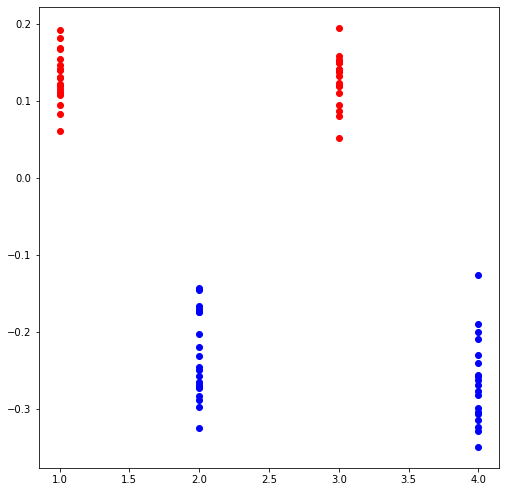

In [12]:
fig = plt.figure(figsize=(16,16))

ax = fig.add_axes([0.05,0.7,0.4,0.4])

ax.plot(np.arange(0,nino34_l83_sst_w.M.size,1)*0 + 1, nino34_l83_sst_w, "o", color='red')
ax.plot(np.arange(0,nino34_l83_sst_e.M.size,1)*0 + 2, nino34_l83_sst_e, "o", color='blue')
ax.plot(np.arange(0,nino34_l32_sst_w.M.size,1)*0 + 3, nino34_l32_sst_w, "o", color='red')
ax.plot(np.arange(0,nino34_l32_sst_e.M.size,1)*0 + 4, nino34_l32_sst_e, "o", color='blue')

In [13]:
mjo_obs_region = avg.cosweightlonlat(mjo_obs.MJO_OLR, 50, 170, -20, 5)
mjo_l83_region = avg.cosweightlonlat(mjo_l83.MJO_OLR, 50, 170, -20, 5)
mjo_l32_region = avg.cosweightlonlat(mjo_l32.MJO_OLR, 50, 170, -20, 5)

sst_obs_region = avg.cosweightlonlat(sst_obs, 190, 240, -5, 5)
sst_l83_region = avg.cosweightlonlat(sst_l83, 190, 240, -5, 5)
sst_l32_region = avg.cosweightlonlat(sst_l32, 190, 240, -5, 5)

In [ ]:
# Bootstrapping members for each year and stringing together.
boot_mjo_l83 = [] ; boot_sst_l83 = [] ; boot_qbo_l83 = []
boot_mjo_l32 = [] ; boot_sst_l32 = [] ; boot_qbo_l32 = []
for iyear in np.arange(0,mjo_obs.init_year.size,1):
    boot_mjo = boot.bootgen(mjo_l83_region.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_sst = boot.bootgen(sst_l83_region.TS.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_qbo = boot.bootgen(qbo_l83.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_mjo_l83.append(boot_mjo)
    boot_sst_l83.append(boot_sst)
    boot_qbo_l83.append(boot_qbo)
    
    boot_mjo = boot.bootgen(mjo_l32_region.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_sst = boot.bootgen(sst_l32_region.TS.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_qbo = boot.bootgen(qbo_l32.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_mjo_l32.append(boot_mjo)
    boot_sst_l32.append(boot_sst)
    boot_qbo_l32.append(boot_qbo)     
    
boot_mjo_l83 = xr.concat(boot_mjo_l83, dim=mjo_obs.init_year)
boot_sst_l83 = xr.concat(boot_sst_l83, dim=mjo_obs.init_year)
boot_qbo_l83 = xr.concat(boot_qbo_l83, dim=mjo_obs.init_year)

boot_mjo_l32 = xr.concat(boot_mjo_l32, dim=mjo_obs.init_year)
boot_sst_l32 = xr.concat(boot_sst_l32, dim=mjo_obs.init_year)
boot_qbo_l32 = xr.concat(boot_qbo_l32, dim=mjo_obs.init_year)

In [29]:
boot_qbo_obs = xr.DataArray(np.zeros([boot_qbo_l83.init_year.size, boot_qbo_l83.iboot.size]), dims=['init_year','iboot'], 
                            coords=[boot_qbo_l83.init_year, boot_qbo_l83.iboot], name='boot_qbo_obs')
boot_qbo_obs[:,:] = qbo_obs

In [32]:
# composites for regions
bootcomp_l83 = composite_w_e(boot_qbo_obs, boot_sst_l83, boot_mjo_l83)
bootcomp_l32 = composite_w_e(boot_qbo_obs, boot_sst_l32, boot_mjo_l32)
compregions_obs = composite_w_e(qbo_obs, sst_obs_region, mjo_obs_region)
compregions_l83 = composite_w_e(qbo_obs, sst_l83_region.TS, mjo_l83_region)
compregions_l32 = composite_w_e(qbo_obs, sst_l32_region.TS, mjo_l32_region)